In [1]:
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
sns.set_theme()

## 1

In [2]:
cols_dtype={'ITEM_ID':np.uint16,'PERIOD_ID':np.uint16,'STORE_ID':'str','PROMO':np.uint8}

In [3]:
data=pd.read_csv('df1.csv',usecols=['ITEM_ID','STORE_ID','PERIOD_ID','SALES_UNITS_EXPANDED','SALES_VOLUME_EXPANDED','SALES_VALUE_EXPANDED'],
                 dtype={'ITEM_ID':np.uint16,'PERIOD_ID':np.uint16,'STORE_ID':'str'})

In [4]:
print(data.shape,data.memory_usage().sum()/2**20)

(7500185, 6) 257.49853897094727


In [5]:
temp=pd.concat([data.dtypes,data.isna().sum(),data.nunique()],axis=1)
temp.columns=['dtype','na_count','nunique']
temp

,dtype,na_count,nunique
ITEM_ID,uint16,0,8
STORE_ID,object,0,32489
PERIOD_ID,uint16,0,95
SALES_UNITS_EXPANDED,int64,0,203
SALES_VOLUME_EXPANDED,float64,0,1383
SALES_VALUE_EXPANDED,float64,0,533465


In [6]:
(data[['SALES_VALUE_EXPANDED','SALES_VOLUME_EXPANDED','SALES_UNITS_EXPANDED']]==0).sum()

SALES_VALUE_EXPANDED     266
SALES_VOLUME_EXPANDED      0
SALES_UNITS_EXPANDED       0
dtype: int64

In [7]:
data=(data.loc[data['SALES_VALUE_EXPANDED']!=0,:]).copy()

In [8]:
data['ACTUAL_PRICE']=(data['SALES_VALUE_EXPANDED']/data['SALES_UNITS_EXPANDED']).round(2)
data['weight']=(data['SALES_VOLUME_EXPANDED']/data['SALES_UNITS_EXPANDED']).round(2)

## 2

In [ ]:
# 1. Draw a histogram of SALES UNITS EXPANDED for each item # 
(a) What distribution does it follow? It is the same for all items<br># 
(b) Does the answer change if we applied a log transformation?

In [ ]:
# (a) Распределение - экспоненциальное 
# (b) После логарифмирования снизилась ассиметрия, но до нормального распределения ещё далеко

1


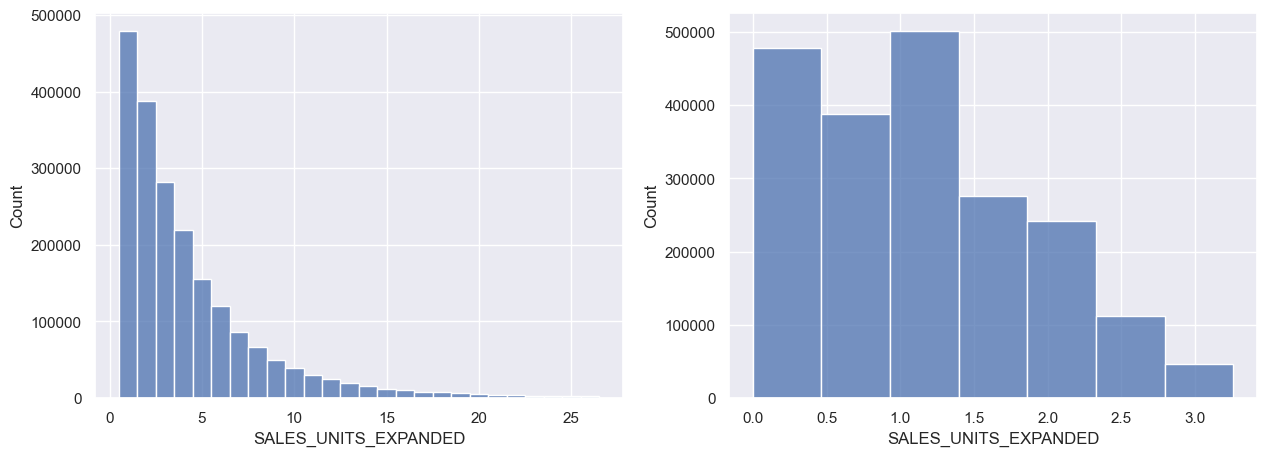

2


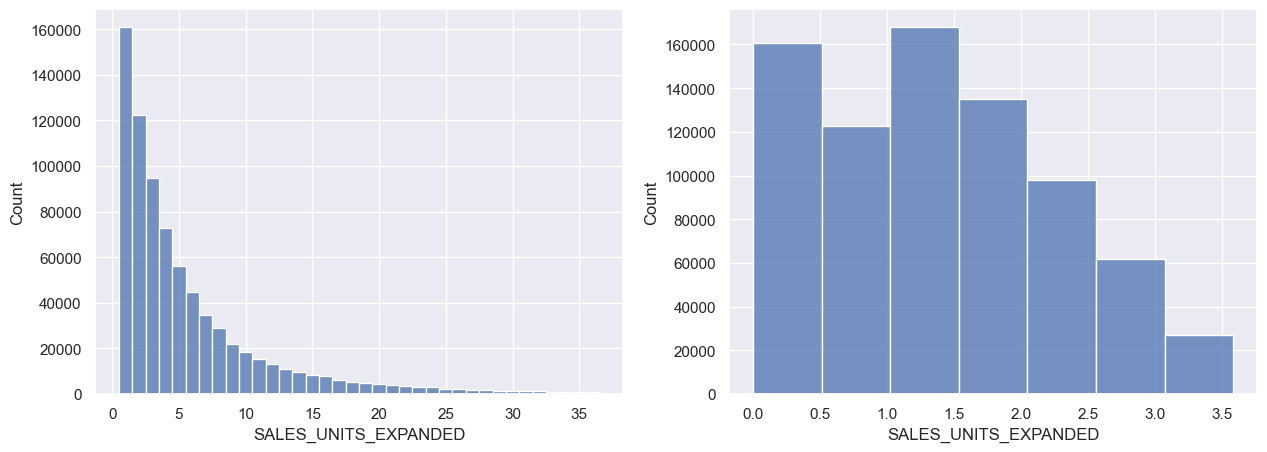

3


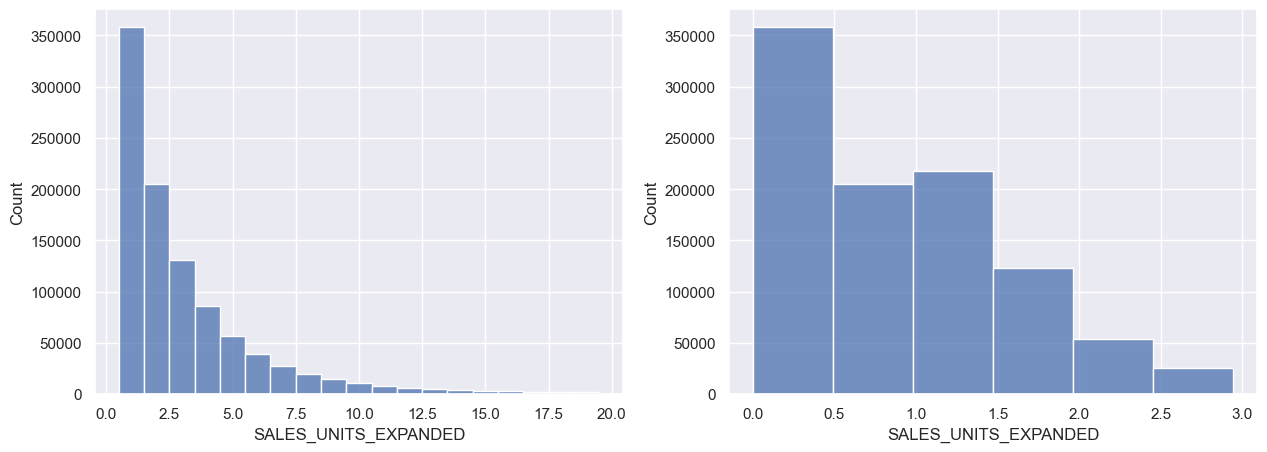

4


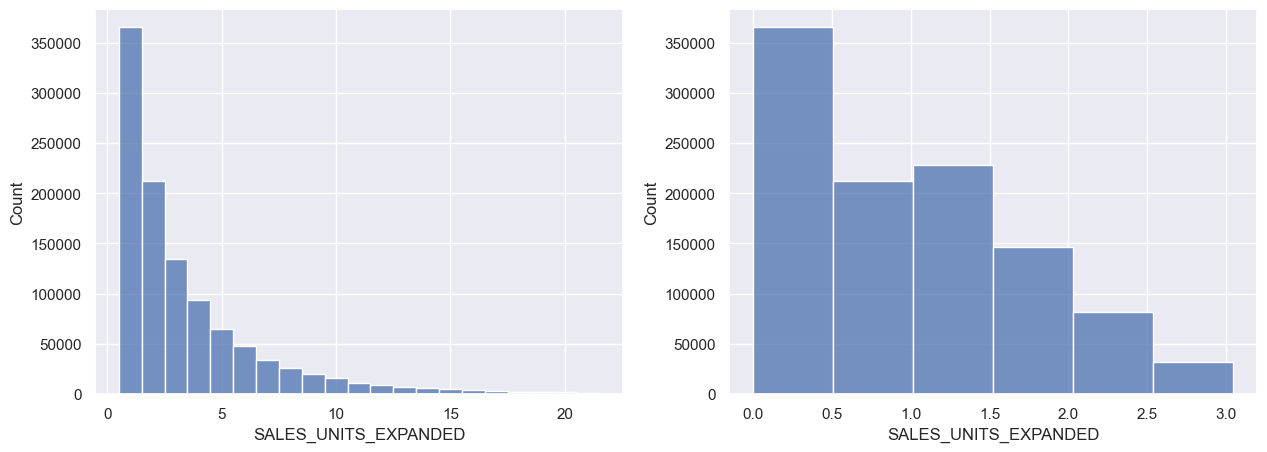

5


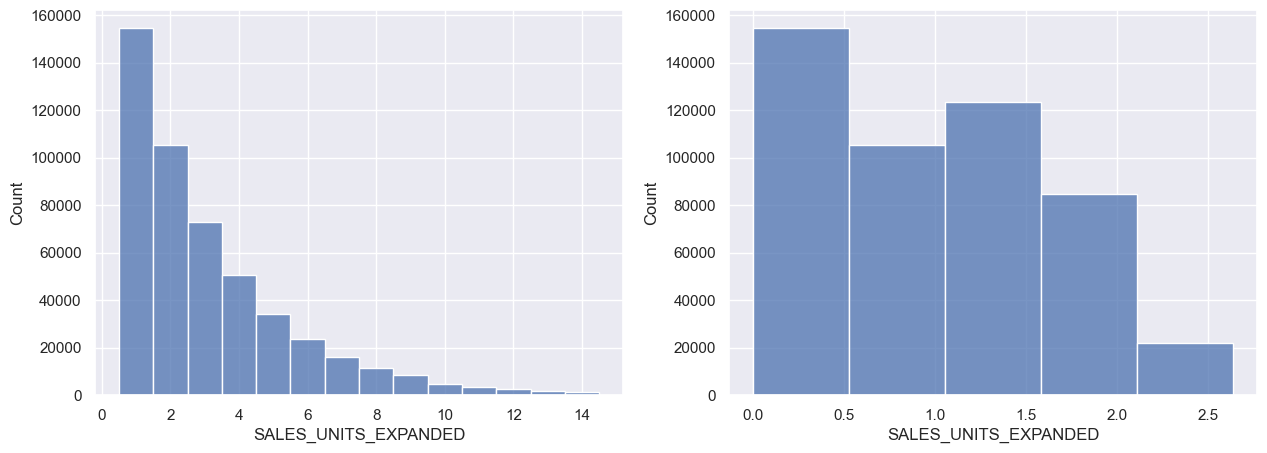

6


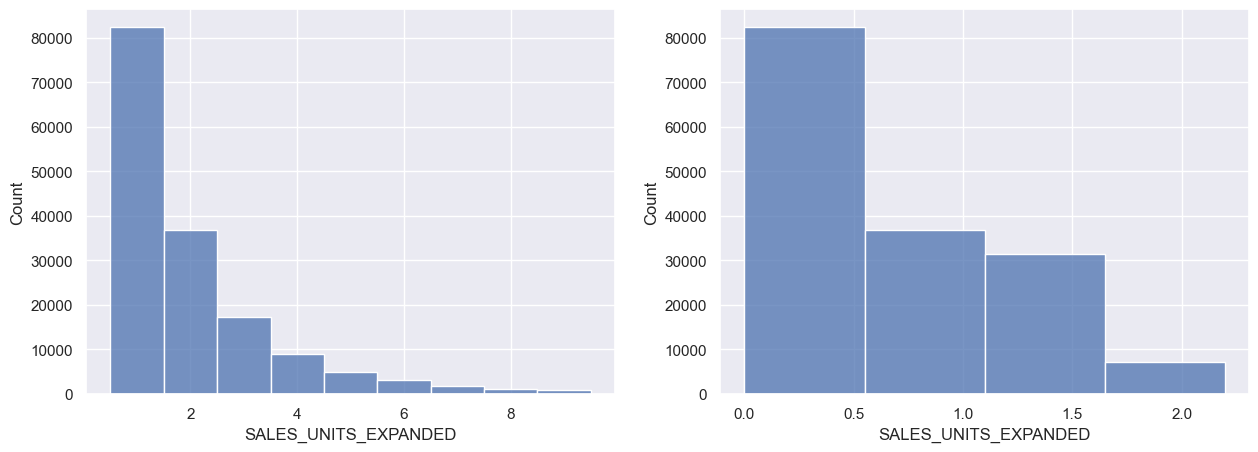

7


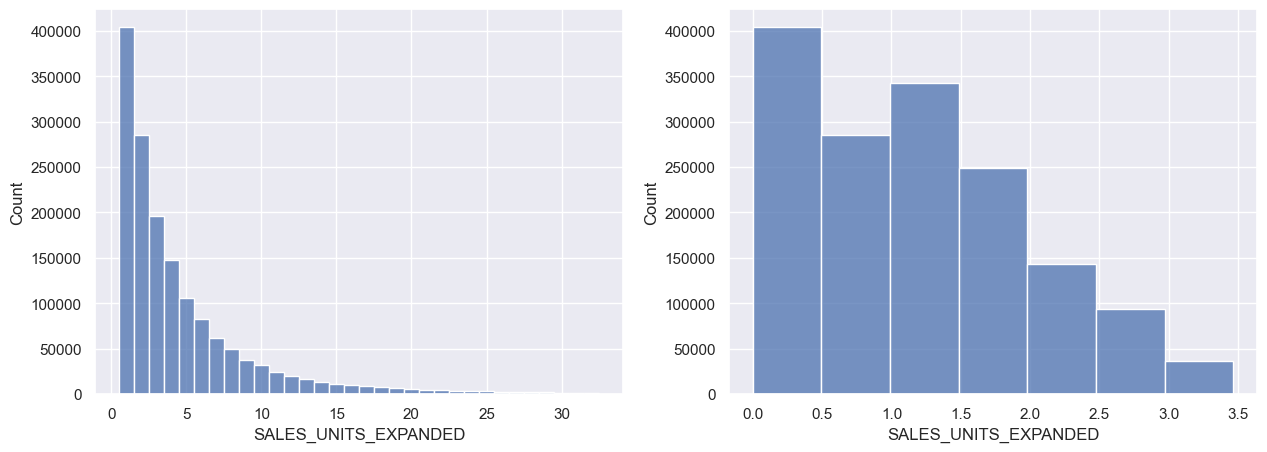

8


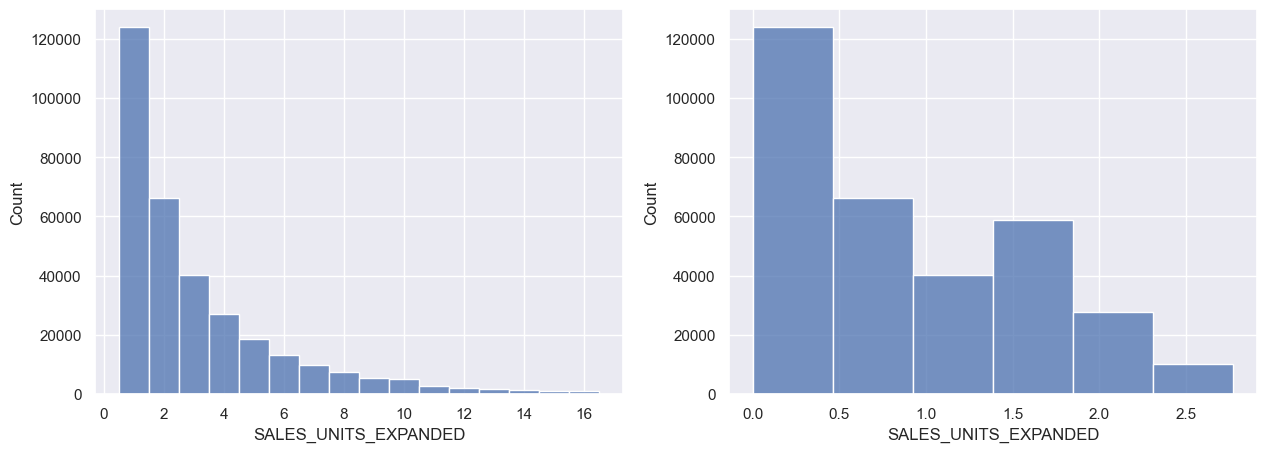

In [85]:
for item in sorted(data['ITEM_ID'].unique()):
    print(item)
    item_sales=data.loc[data['ITEM_ID']==item,'SALES_UNITS_EXPANDED']
    item_sales=item_sales[item_sales<item_sales.quantile(0.99)]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(item_sales,discrete=True,ax=axes[0])
    item_sales_log=np.log(item_sales)
    sns.histplot(item_sales_log,binwidth=0.5,ax=axes[1])
    plt.show()

In [ ]:
# 2. Draw SALES UNITS EXPANDED and ACTUAL PRICE on a single graph with PERIOD ID on the x-axis for
# each item
# (a) Do you notice any seasonal patterns? Is it similar for all items?
# (b) Can we deduce that price reductions lead to sales increase from this graph? Why/Why not?
# Now plot a second graph with SALES UNITS EXPANDED and number of shops with PERIOD ID on the x-axis
# (c) Does this support your conclusion in (b)?

In [ ]:
# (a) Графиков недостаточно для выявления сезонности
# (b) Нет, не можем. По графику можно увидеть только слабую корреляцию этих параметров. Причинно следственная связь из этого не следует.
# (c) Нет, не меняет

1


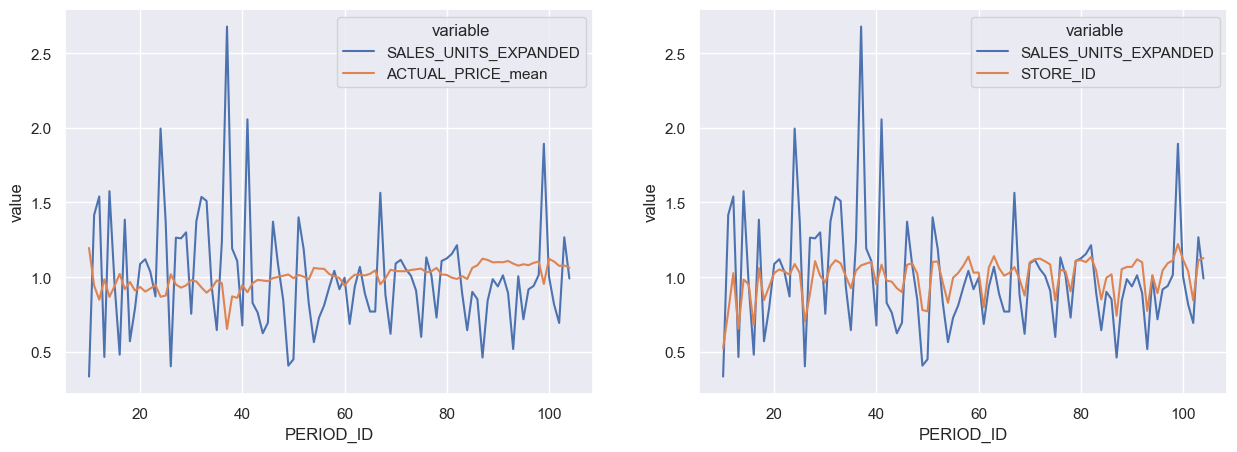

2


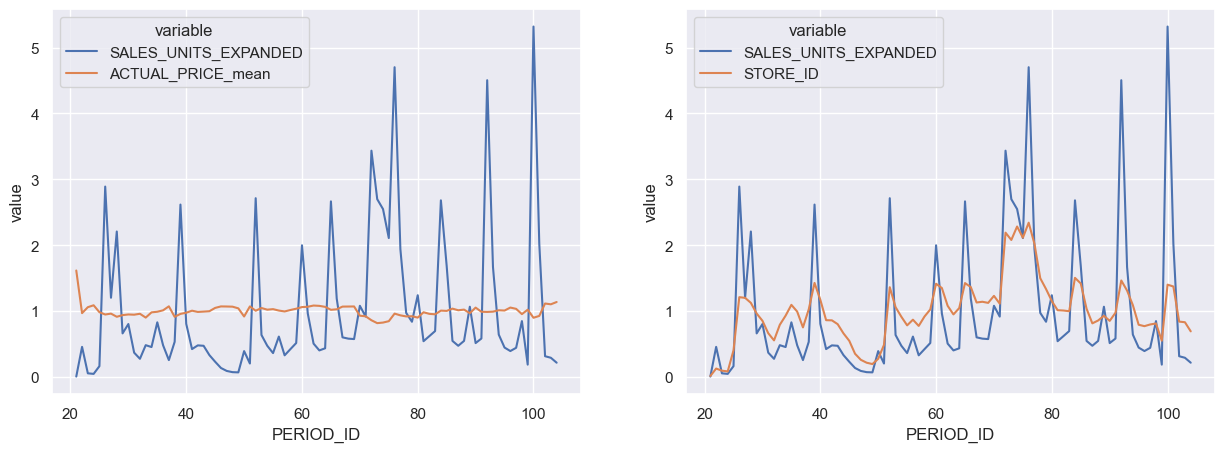

3


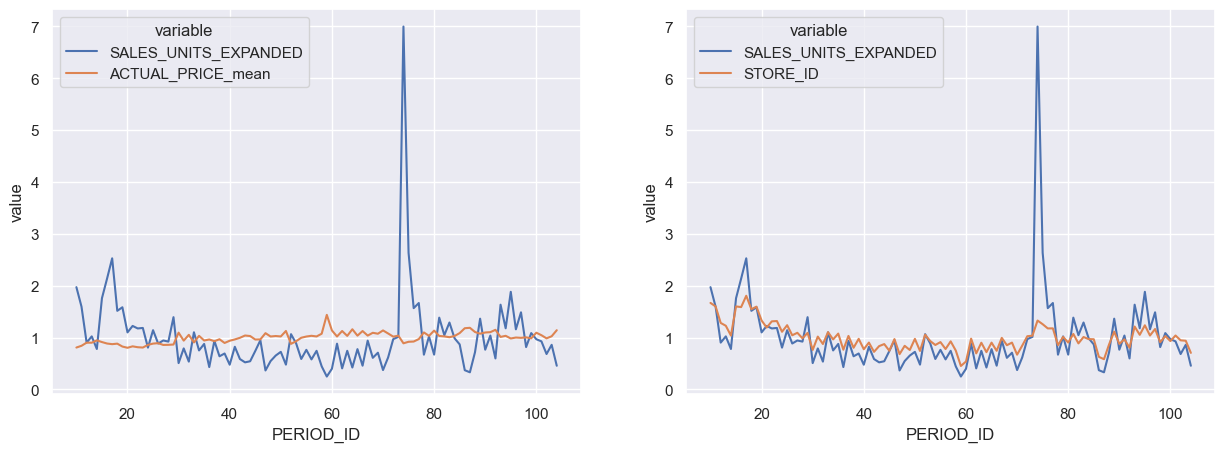

4


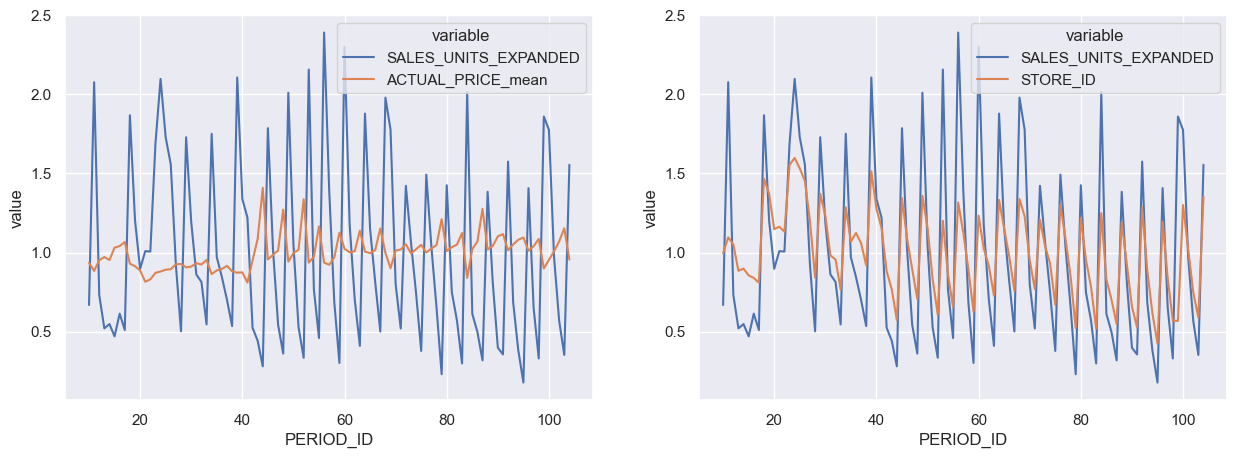

5


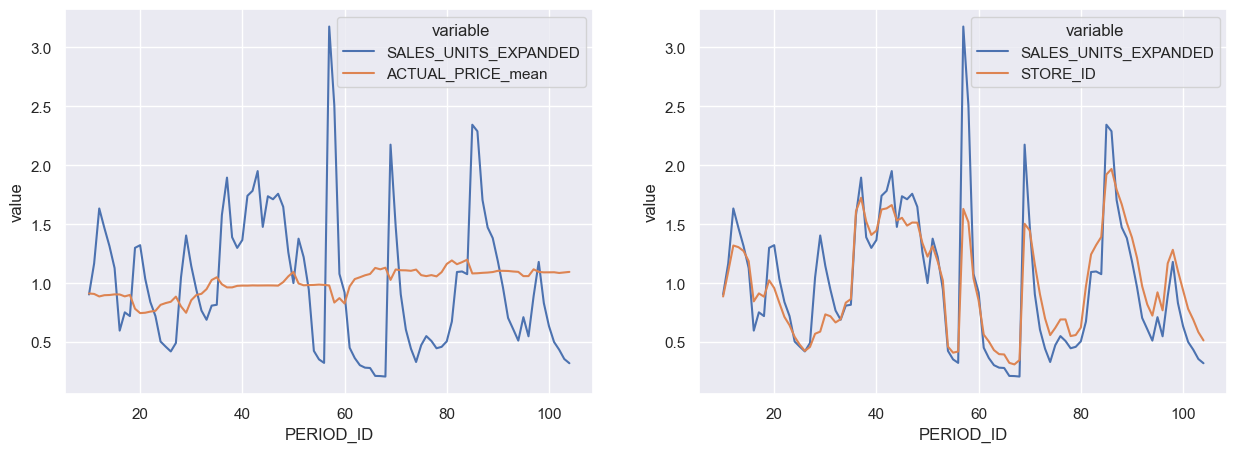

6


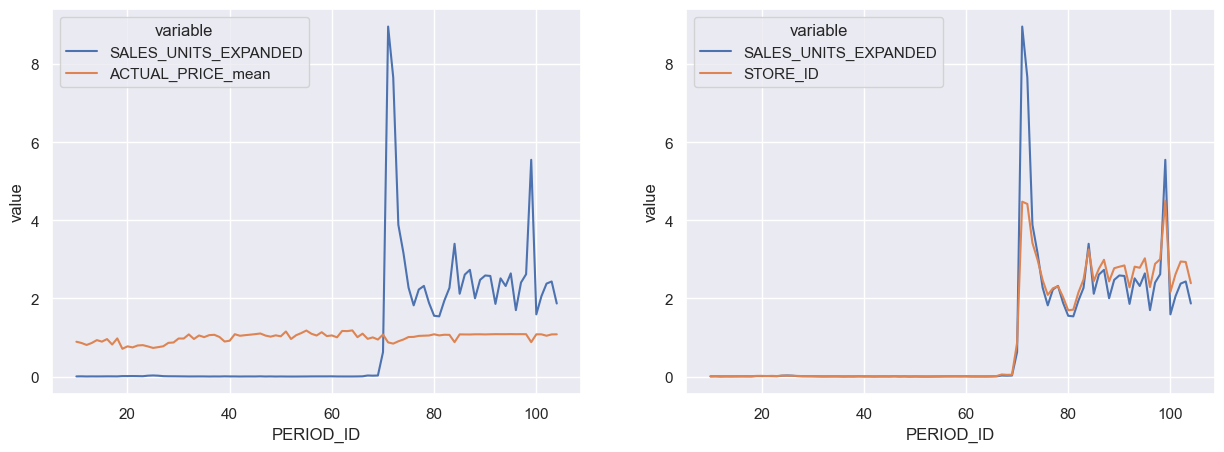

7


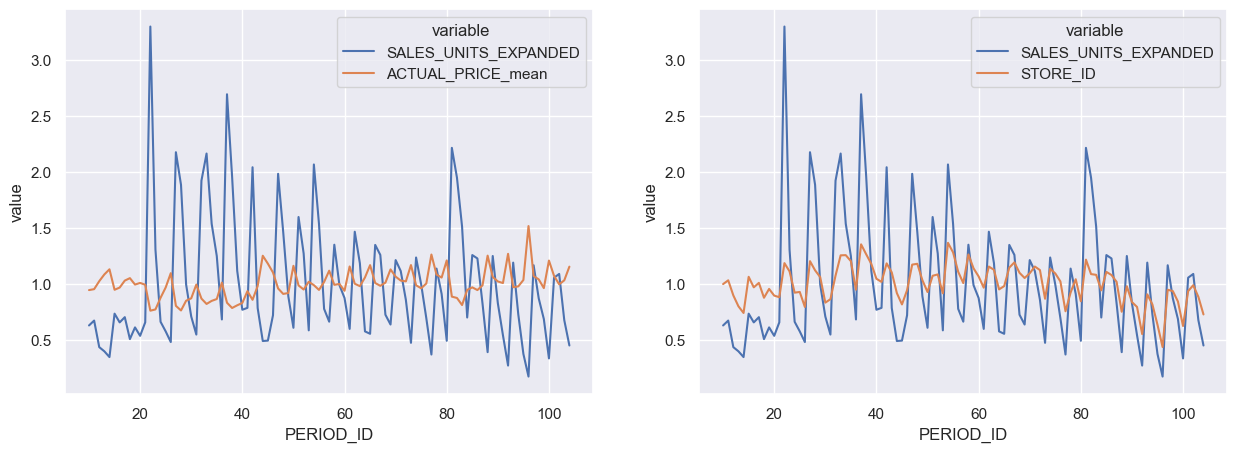

8


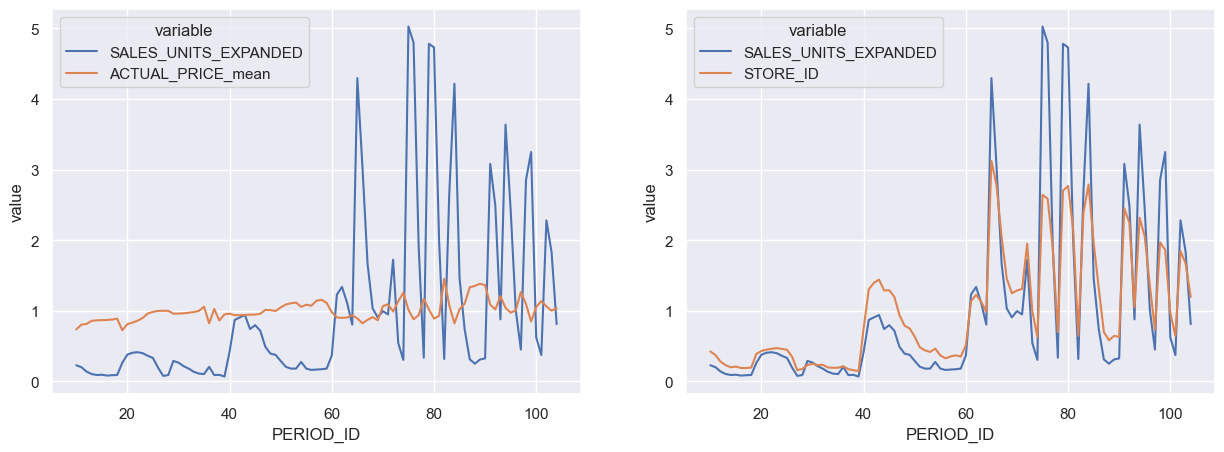

In [79]:
for item in sorted(data['ITEM_ID'].unique()):
    print(item)
    temp=data[data['ITEM_ID']==item].groupby('PERIOD_ID').agg({'SALES_UNITS_EXPANDED':'sum','SALES_VALUE_EXPANDED':'sum','STORE_ID':'nunique'})
    
    temp[('ACTUAL_PRICE_mean')]=temp['SALES_VALUE_EXPANDED']/temp['SALES_UNITS_EXPANDED']
    temp.rename(columns={'ACTUAL_PRICE':'ACTUAL_PRICE_median'},inplace=True)
    
    temp_mean=temp.mean()
    temp['ACTUAL_PRICE_mean']=temp['ACTUAL_PRICE_mean']/temp_mean['ACTUAL_PRICE_mean']
    temp['STORE_ID']=temp['STORE_ID']/temp_mean['STORE_ID']
    temp['SALES_UNITS_EXPANDED']=temp['SALES_UNITS_EXPANDED']/temp_mean['SALES_UNITS_EXPANDED']
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.lineplot(pd.melt(temp.reset_index(),id_vars='PERIOD_ID',value_vars=['SALES_UNITS_EXPANDED','ACTUAL_PRICE_mean']) ,
                 x="PERIOD_ID", y='value',hue='variable',ax=axes[0])

    sns.lineplot(pd.melt(temp.reset_index(),id_vars='PERIOD_ID',value_vars=['SALES_UNITS_EXPANDED','STORE_ID']) ,
                 x="PERIOD_ID", y='value',hue='variable',ax=axes[1])
    plt.show()

## 3

In [19]:
promo_data=pd.read_csv('df2.csv',dtype=cols_dtype)

In [20]:
data=data.merge(promo_data,how='left',on=['ITEM_ID','STORE_ID','PERIOD_ID'])

### Здесь ошибка в разметке промо

In [21]:
data.groupby('PROMO')['PROMOTION_PRICE_INDEX'].mean()

PROMO
0    0.839921
1    1.000000
Name: PROMOTION_PRICE_INDEX, dtype: float64

In [22]:
data.groupby('PROMO')['PROMOTION_PRICE_INDEX'].agg(['max','mean','min'])

,max,mean,min
PROMO,,,
0,3.483914,0.839921,0.000029
1,1.000000,1.000000,1.000000


In [23]:
((data['ACTUAL_PRICE']/data['REGULAR_PRICE']).round(2)!=data['PROMOTION_PRICE_INDEX'].round(2)).sum()

4904

In [24]:
data['PROMOTION_PRICE_INDEX']=data['ACTUAL_PRICE']/data['REGULAR_PRICE']

<Axes: xlabel='PROMOTION_PRICE_INDEX', ylabel='Count'>

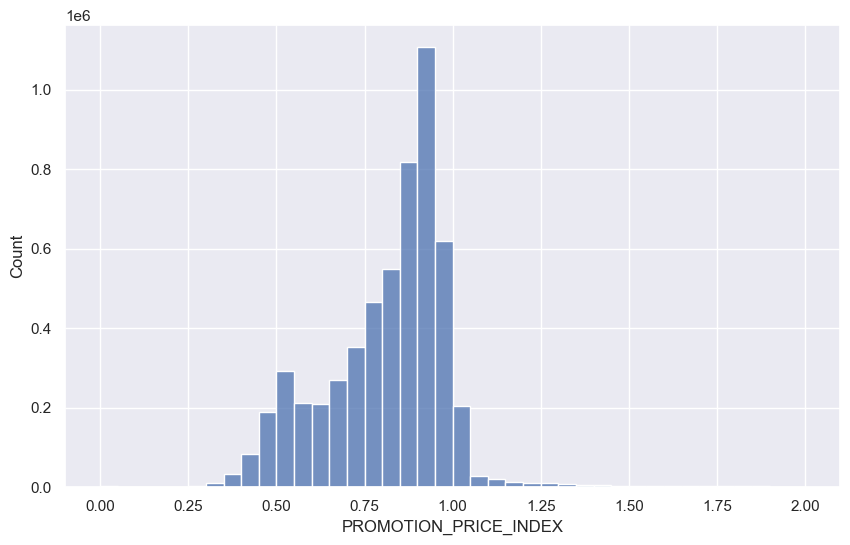

In [25]:
sns.histplot(data.loc[data['PROMOTION_PRICE_INDEX'].round(2)!=1,'PROMOTION_PRICE_INDEX'],binrange=(0,2),binwidth=0.05)

### Удалим выбросы и разметим промо

In [26]:
data[data['PROMOTION_PRICE_INDEX']>1.5].shape[0],data[data['PROMOTION_PRICE_INDEX']<0.1].shape[0]

(21028, 3288)

In [27]:
data=data[(data['PROMOTION_PRICE_INDEX']<=1.5)&(data['PROMOTION_PRICE_INDEX']>=0.1)]

In [28]:
data['PROMO']=(data['PROMOTION_PRICE_INDEX']<=0.95).astype(np.uint8)

In [ ]:
data=data.sort_values(['PERIOD_ID']).reset_index(drop=True)
data['promo_invert']=~(data['PROMO'].astype('bool'))
data['promo_seq']=data.groupby(['ITEM_ID','STORE_ID'])['promo_invert'].cumsum(axis=0)
shop_info=data.loc[data['PROMO']==1].groupby(['ITEM_ID','STORE_ID','promo_seq']).size().reset_index()
shop_info=shop_info.groupby(['ITEM_ID','STORE_ID'])[0].max().reset_index()
shop_info.rename(columns={0:'max_promo_seq'},inplace=True)
data=data.merge(shop_info,how='left',on=['ITEM_ID','STORE_ID']).fillna({'max_promo_seq':0})
data['total_period_cnt']=data.groupby(['ITEM_ID','STORE_ID']).transform('size')

data['PROMO_SHOP']=((data['max_promo_seq']/data['total_period_cnt'])>=0.75).astype(np.uint8)

In [40]:
data.drop(columns=['promo_seq','max_promo_seq','total_period_cnt'],inplace=True)

In [ ]:
data['REGULAR_SALES_VALUE_EXPANDED']=data['SALES_UNITS_EXPANDED']*data['REGULAR_PRICE']

total_sales=data.groupby('ITEM_ID')[['SALES_UNITS_EXPANDED','SALES_VALUE_EXPANDED']].sum()
total_sales['Weighted_Price']=total_sales['SALES_VALUE_EXPANDED']/total_sales['SALES_UNITS_EXPANDED']
total_sales=total_sales.drop(columns=['SALES_VALUE_EXPANDED']).rename(columns={'SALES_UNITS_EXPANDED':'Total_Sales'})

promo_sales=data[data['PROMO']==1].groupby('ITEM_ID')[['SALES_UNITS_EXPANDED']].sum()
promo_sales.columns=['Promo_Sales']

reg_price=data[data['PROMO_SHOP']==0].groupby('ITEM_ID')[['SALES_UNITS_EXPANDED','REGULAR_SALES_VALUE_EXPANDED']].sum()
reg_price['Weighted_Regular_Price']=reg_price['REGULAR_SALES_VALUE_EXPANDED']/reg_price['SALES_UNITS_EXPANDED']
reg_price=reg_price[['Weighted_Regular_Price']]

item_summary=pd.concat([total_sales,promo_sales,reg_price],axis=1)
item_summary['Promo_Sales_Share']=item_summary['Promo_Sales']/item_summary['Total_Sales']

In [ ]:
# (a) Which items appear to be similar to each other in terms of weighted regular price? What about weighted price?
# (b) Which item has the highest sales? Does it also have the highest share of promo sales?

In [ ]:
# (a) По средней регулярной цене ближе всего 2 и 4. По средней цене блмже всего 1 и 2
# (b) Наибольшие продажи у 1. Наибольшая доля промо-продаж у 7

In [87]:
item_summary.sort_values(by='Promo_Sales_Share')

,Total_Sales,Weighted_Price,Promo_Sales,Weighted_Regular_Price,Promo_Sales_Share
ITEM_ID,,,,,
6,343511,272.780445,130598,296.457897,0.380186
5,1647379,150.570043,867132,170.330762,0.526371
1,9699417,163.614538,6422543,185.614918,0.662158
8,1104315,141.517456,746671,180.930376,0.676140
2,4853155,158.870300,3306747,176.793928,0.681360
3,3402152,86.984257,2397071,104.605091,0.704575
4,4074754,133.569021,2973765,174.950248,0.729802
7,7982808,87.900804,6991636,141.206202,0.875837


<Axes: xlabel='ITEM_ID', ylabel='ITEM_ID'>

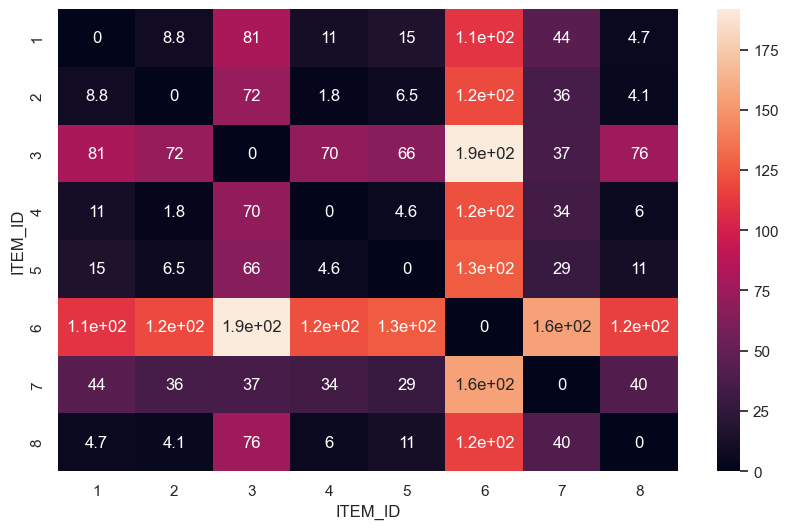

In [47]:
temp=item_summary['Weighted_Regular_Price']
sqr_matr=pd.DataFrame([temp]*len(temp),index=temp.index,columns=temp.index)
sns.heatmap((sqr_matr-sqr_matr.T).abs(),annot=True)

<Axes: xlabel='ITEM_ID', ylabel='ITEM_ID'>

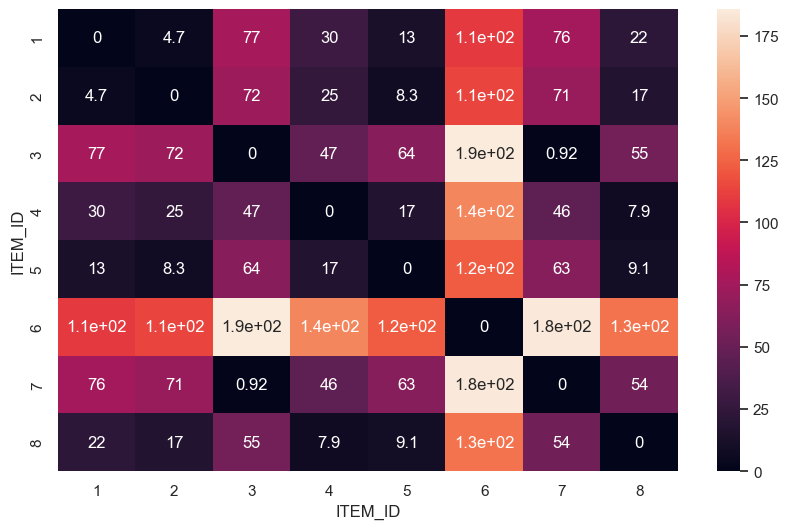

In [46]:
temp=item_summary['Weighted_Price']
sqr_matr=pd.DataFrame([temp]*len(temp),index=temp.index,columns=temp.index)
sns.heatmap((sqr_matr-sqr_matr.T).abs(),annot=True)

## 4

In [88]:
#List necessary and sufficient assumption to get a consistent and asymptotically normal estimate of the marginal
# impact of price parameters on sales using Ordinary Least Squares (OLS)?
#  1) Линейная связь между зависимыми и независимыми переменными
#  2) Экзогенность. Все независимые переменные не коррелируют с ошибкой
#  3) Дисперсия ошибок должна быть постоянной для всех наблюдений.
#  4) Нет Автокорреляция
#  5) Нет Мультиколлинеарности
# • Do we require normality of errors to obtain consistent estimate?
# Нет, но нарушения нормальности создают проблемы для определения существенного отличия коэффициентов модели от нуля и расчета доверительных интервалов.
# • How does violating spherical errors assumption impact consistency of the estimate?
#


In [48]:
x_cols=['REGULAR_PRICE','PROMO','PROMOTION_PRICE_INDEX']
y_col='SALES_UNITS_EXPANDED'

x_data=data[x_cols].copy()
y_data=data[y_col].copy()

x_data['REGULAR_PRICE']=np.log(x_data['REGULAR_PRICE'])
x_data['PROMOTION_PRICE_INDEX']=np.log(x_data['PROMOTION_PRICE_INDEX'])

y_data=np.log(y_data)

In [49]:
import statsmodels.api as sm

In [50]:
x,y=x_data,y_data
x=sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()

In [51]:
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.051
Model:                              OLS   Adj. R-squared:                  0.051
Method:                   Least Squares   F-statistic:                 1.343e+05
Date:                  Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                          15:59:08   Log-Likelihood:            -9.4925e+06
No. Observations:               7475603   AIC:                         1.899e+07
Df Residuals:                   7475599   BIC:                         1.899e+07
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

In [ ]:
# (a) Interpret coefficient estimates. Which sign would we expect? What values did we get?
# Знаки для промо и промо индекса ожидаемы. 
#  Увеличение промо ожидаемо увеличивает продажи.
#  Уменьшение промо индекса = увеличение глубины скидки 
#  У регулярной цены положительный коэфф. Возможно, поднятие регулярной цены сопровождается промо, но коэфф. очень мал, а условия для t-теста не проверялись.

# (c) Do you think this multiplicative specification is more realistic compared to standard linear model? Explain
# REGULAR_PRICE и PROMOTION_PRICE_INDEX при умножении дают реальную цену, так что с такими переменными лучше использовать мультипликативную модель.

In [54]:
season_dict={1:(10,41),2:(42,73),3:(74,104)}

season_cols=['REGULAR_PRICE']
for key,value in season_dict.items():
    for col in ['PROMOTION_PRICE_INDEX','PROMO']:
        if col=='PROMO':
            data[f'{col}_{key}']=data[col]*((data['PERIOD_ID']>=value[0])&(data['PERIOD_ID']<=value[1]))
        elif col=='REGULAR_PRICE':
            data[f'{col}_{key}']=data[col]*((data['PERIOD_ID']>=value[0])&(data['PERIOD_ID']<=value[1]))
        else:
            data[f'{col}_{key}']=np.log(data[col])*((data['PERIOD_ID']>=value[0])&(data['PERIOD_ID']<=value[1]))
        season_cols.append(f'{col}_{key}')

In [55]:
x_season_data=data[season_cols].copy()

In [56]:

x,y=x_season_data,y_data
x=sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()

In [57]:
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.052
Model:                              OLS   Adj. R-squared:                  0.052
Method:                   Least Squares   F-statistic:                 5.855e+04
Date:                  Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                          15:59:18   Log-Likelihood:            -9.4892e+06
No. Observations:               7475603   AIC:                         1.898e+07
Df Residuals:                   7475595   BIC:                         1.898e+07
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

## 5

In [66]:
data_comp=data.loc[data['ITEM_ID']==1,['ITEM_ID','STORE_ID','PERIOD_ID','REGULAR_PRICE','PROMO','PROMOTION_PRICE_INDEX']].copy()
for i in list(set(data['ITEM_ID'].unique())-set([1])):
    data_comp=data_comp.merge(data.loc[data['ITEM_ID']==i,['STORE_ID','PERIOD_ID','REGULAR_PRICE','PROMO','PROMOTION_PRICE_INDEX']],
                              on=['STORE_ID','PERIOD_ID'],how='left',suffixes=('',f'_comp_{i}'))
    data_comp.loc[:,[f'REGULAR_PRICE_com_{i}',f'PROMOTION_PRICE_INDEX_comp_{i}']].fillna()
    

In [63]:
data_comp=data_comp.merge(data_comp,on=['STORE_ID','PERIOD_ID'],how='left',suffixes=('','_comp'))

In [89]:
data_comp.head(10)

,ITEM_ID,STORE_ID,PERIOD_ID,REGULAR_PRICE,PROMO,PROMOTION_PRICE_INDEX,REGULAR_PRICE_comp_3,PROMO_comp_3,PROMOTION_PRICE_INDEX_comp_3,REGULAR_PRICE_comp_8,...,PROMOTION_PRICE_INDEX_comp_5,REGULAR_PRICE_comp_1,PROMO_comp_1,PROMOTION_PRICE_INDEX_comp_1,REGULAR_PRICE_comp_6,PROMO_comp_6,PROMOTION_PRICE_INDEX_comp_6,REGULAR_PRICE_comp_2,PROMO_comp_2,PROMOTION_PRICE_INDEX_comp_2
0,3,26699,10,79.90,1,0.849812,79.90,1.0,0.849812,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,6503,10,129.90,1,0.722864,NaN,NaN,NaN,129.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,24096,10,125.90,0,1.000000,125.90,0.0,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,23362,10,79.59,0,1.000000,79.62,0.0,0.965210,NaN,...,NaN,223.63,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,7,18416,10,136.55,1,0.584767,79.79,1.0,0.750094,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4,9870,10,124.40,0,1.000000,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,9968,10,89.90,0,1.000000,111.90,1.0,0.714030,NaN,...,1.000000,169.00,1.0,0.697633,NaN,NaN,NaN,NaN,NaN,NaN
7,3,17830,10,79.70,0,1.000000,79.70,0.0,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5,3390,10,149.00,1,0.932886,79.96,0.0,1.000000,NaN,...,0.932886,239.45,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
9,1,1771,10,169.90,0,1.000000,79.90,1.0,0.874844,NaN,...,NaN,169.90,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


## Weight

In [9]:
temp=data.groupby('ITEM_ID')['weight'].nunique()
temp[temp>1]

ITEM_ID
1    11
2     9
Name: weight, dtype: int64

In [10]:
data[(data['SALES_UNITS_EXPANDED']==1)&(data['ITEM_ID'].isin(temp[temp>1].index))].groupby(['ITEM_ID','weight']).size()

ITEM_ID  weight
1        0.90        1265
         1.00      478632
2        0.15       44937
         0.23      116113
dtype: int64

In [11]:
temp=data[data['SALES_UNITS_EXPANDED']==1].groupby(['ITEM_ID'])['PERIOD_ID'].idxmin()
item_weight=data.loc[temp]['weight']
item_weight.index=temp.index

In [12]:
data=data.merge(item_weight,how='left',on='ITEM_ID',suffixes=('','_start'))
data['weight_norm']=data['weight']/data['weight_start']

<Axes: xlabel='PERIOD_ID', ylabel='weight_norm'>

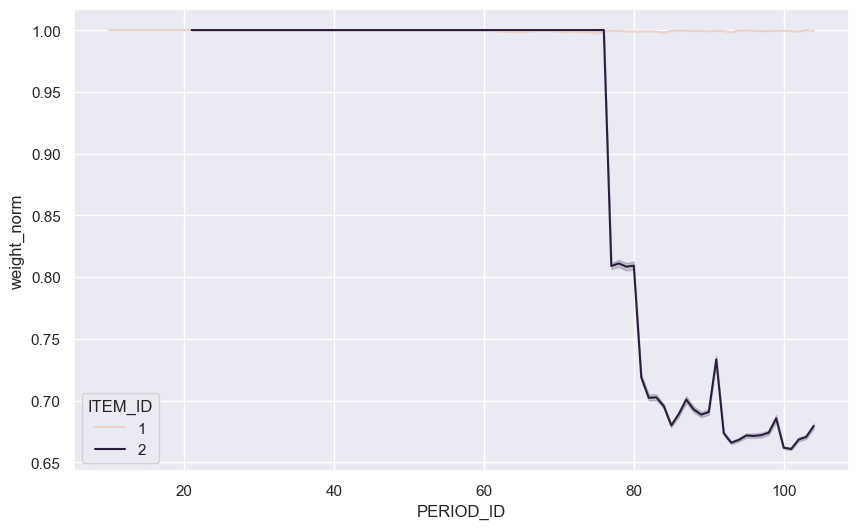

In [13]:
sns.lineplot(data=data[data['ITEM_ID'].isin([1,2])],x='PERIOD_ID',y='weight_norm',hue='ITEM_ID')